<img width="800px" src="../fidle/img/header.svg"></img>

# <!-- TITLE --> [K3GTSRB3] - Training monitoring
<!-- DESC --> Episode 3 : Monitoring, analysis and check points during a training session, using Keras3
<!-- AUTHOR : Jean-Luc Parouty (CNRS/SIMaP) -->

## Objectives :
  - **Understand** what happens during the **training** process
  - Implement **monitoring**, **backup** and **recovery** solutions
  
The German Traffic Sign Recognition Benchmark (GTSRB) is a dataset with more than 50,000 photos of road signs from about 40 classes.  
The final aim is to recognise them !  
Description is available there : http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset

## What we're going to do :

 - Monitoring and understanding our model training 
 - Add recovery points
 - Analyze the results 
 - Restore and run recovery points 

## Step 1 - Import and init
### 1.1 - Python stuffs

In [8]:
import os
os.environ['KERAS_BACKEND'] = 'torch'

import keras

import numpy as np
import os, random

import fidle

import sys
sys.path.append('/notebooks/fidle-pre-master-3.0.9/GTSRB.Keras3/modules')

import my_loader
import my_models
import my_tools
from my_TensorboardCallback import TensorboardCallback

# Init Fidle environment
run_id, run_dir, datasets_dir = fidle.init('K3GTSRB3')

<br>**FIDLE - Environment initialization**

Version              : 2.3.2
Run id               : K3GTSRB3
Run dir              : ./run/K3GTSRB3
Datasets dir         : /data/datasets-fidle
Start time           : 05/07/24 10:24:00
Hostname             : ebf2030c9b9e (Linux)
Tensorflow log level : Info + Warning + Error  (=0)
Update keras cache   : False
Update torch cache   : False
Save figs            : ./run/K3GTSRB3/figs (False)
keras                : 3.0.5
numpy                : 1.26.4
sklearn              : 1.4.1.post1
yaml                 : 6.0.1
matplotlib           : 3.8.3
pandas               : 2.2.1
torch                : 2.2.1+cpu


### 1.2 - Parameters
`scale` is the proportion of the dataset that will be used during the training. (1 mean 100%)  
- A 20% 24x24 L dataset, 10 epochs, 20% dataset, need  1'30 on a CPU laptop. (Accuracy=91.4)\
- A 20% 48x48 RGB dataset, 10 epochs, 20% dataset, need 6'30s on a CPU laptop. (Accuracy=91.5)

`model_name` is the model name from modules.my_models :  
- model_01 for 24x24 ou 48x48 images
- model_02 for 48x48 images

`fit_verbosity` is the verbosity during training : 
- 0 = silent, 1 = progress bar, 2 = one line per epoch

In [9]:
enhanced_dir = './data'
# enhanced_dir = f'{datasets_dir}/GTSRB/enhanced'

model_name   = 'model_01'
dataset_name = 'set-24x24-L'
batch_size   = 64
epochs       = 10
scale        = 1
fit_verbosity = 1

Override parameters (batch mode) - Just forget this cell

In [10]:
fidle.override('enhanced_dir', 'model_name', 'dataset_name', 'batch_size', 'epochs', 'scale', 'fit_verbosity')

## Step 2 - Load dataset
Dataset is one of the saved dataset...

In [11]:
x_train,y_train,x_test,y_test, x_meta,y_meta = my_loader.read_dataset(enhanced_dir, dataset_name, scale)

Original shape  : (7841, 24, 24, 1) (7841,)
Datasets have been resized with a factor  1
Rescaled shape  : (7841, 24, 24, 1) (7841,)
Datasets have been shuffled.

Dataset "set-24x24-L" is loaded and shuffled. (23.1 Mo in 0:00:00)


## Step 3 - Have a look to the dataset

x_train :  (7841, 24, 24, 1)
y_train :  (7841,)
x_test  :  (2526, 24, 24, 1)
y_test  :  (2526,)


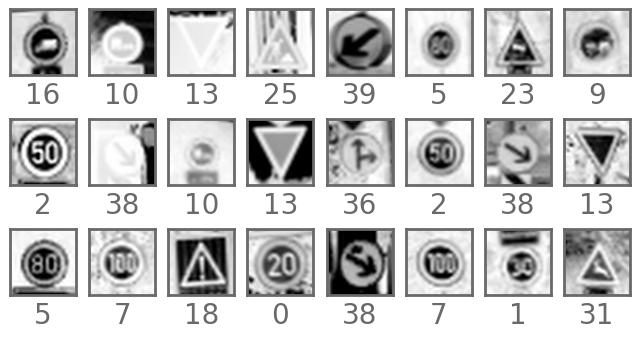

In [12]:
print("x_train : ", x_train.shape)
print("y_train : ", y_train.shape)
print("x_test  : ", x_test.shape)
print("y_test  : ", y_test.shape)

fidle.scrawler.images(x_train, y_train, range(24), columns=8, x_size=1, y_size=1, save_as='02-dataset-small')

## Step 4 - Get a model

In [13]:
(n,lx,ly,lz) = x_train.shape

model = my_models.get_model( model_name, lx,ly,lz )
model.summary()

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 22, 22, 96)     │           960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 11, 11, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 11, 11, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 9, 9, 192)      │       166,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 4, 4, 192)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4, 4, 192)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1500)           │     4,609,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1500)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 43)             │        64,543 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,841,083 (18.47 MB)

 Trainable params: 4,841,083 (18.47 MB)

 Non-trainable params: 0 (0.00 B)

## Step 5 - Prepare callbacks  
We will add 2 callbacks :  

**TensorBoard**  
Training logs, which can be visualised using [Tensorboard tool](https://www.tensorflow.org/tensorboard).  

**Model backup**  
 It is possible to save the model each xx epoch or at each improvement.  
 The model can be saved completely or partially (weight).  
 See [Keras documentation](https://keras.io/api/callbacks/)

In [14]:
fidle.utils.mkdir(run_dir + '/models')
fidle.utils.mkdir(run_dir + '/logs')

# ---- Callback for tensorboard (This one is homemade !)
#
tenseorboard_callback = TensorboardCallback(
                                log_dir=run_dir + "/logs/tb_" + fidle.Chrono.tag_now())

# ---- Callback to save best model
#
bestmodel_callback = keras.callbacks.ModelCheckpoint( 
                                filepath= run_dir + "/models/best-model.keras",
                                monitor='val_accuracy', 
                                mode='max', 
                                save_best_only=True)

# ---- Callback to save model from each epochs
#
savemodel_callback = keras.callbacks.ModelCheckpoint(
                                filepath= run_dir + "/models/{epoch:02d}.keras",
                                save_freq="epoch")

## Step 6 - Train the model
To access logs with tensorboad :
- Under **Docker**, from a terminal launched via the jupyterlab launcher, use the following command:<br>
```tensorboard --logdir <path-to-logs> --host 0.0.0.0```
- If you're not using Docker, from a terminal :<br>
```tensorboard --logdir <path-to-logs>```  

**Note:** One tensorboard instance can be used simultaneously.

**Train it :**  
Note: The training curve is visible in real time with Tensorboard (see step  5)

In [15]:
chrono=fidle.Chrono()
chrono.start()

# ---- Shuffle train data
x_train,y_train=fidle.utils.shuffle_np_dataset(x_train,y_train)

# ---- Train
# Note: To be faster in our example, we can take only 2000 values
#
history = model.fit(  x_train, y_train,
                      batch_size=batch_size,
                      epochs=epochs,
                      verbose=fit_verbosity,
                      validation_data=(x_test, y_test),
                      callbacks=[tenseorboard_callback, bestmodel_callback, savemodel_callback] )

model.save(f'{run_dir}/models/last-model.keras')

chrono.show()

Datasets have been shuffled.
Epoch 1/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 44s 353ms/step - accuracy: 0.1064 - loss: 3.3996 - val_accuracy: 0.4893 - val_loss: 1.8867
Epoch 2/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 32s 260ms/step - accuracy: 0.5783 - loss: 1.5019 - val_accuracy: 0.7312 - val_loss: 0.9423
Epoch 3/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 36s 289ms/step - accuracy: 0.7688 - loss: 0.7625 - val_accuracy: 0.8286 - val_loss: 0.6579
Epoch 4/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 33s 267ms/step - accuracy: 0.8510 - loss: 0.4899 - val_accuracy: 0.8745 - val_loss: 0.5347
Epoch 5/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 30s 240ms/step - accuracy: 0.9025 - loss: 0.3318 - val_accuracy: 0.8856 - val_loss: 0.4655
Epoch 6/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 34s 281ms/step - accuracy: 0.9291 - loss: 0.2430 - val_accuracy: 0.8935 - val_loss: 0.4458
Epoch 7/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 35s 288ms/step - accuracy: 0.9407 - loss: 0.1957 - val_accuracy: 0.9050 - val_loss: 0.4111
Epoch 8/10
123/123 ━━━━━━━━━━━━━━━━━━━━ 47s 387ms/step

**Evaluate it :**

In [16]:
max_val_accuracy = max(history.history["val_accuracy"])
print("Max validation accuracy is : {:.4f}".format(max_val_accuracy))

Max validation accuracy is : 0.9133


In [17]:
score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss      : {:5.4f}'.format(score[0]))
print('Test accuracy  : {:5.4f}'.format(score[1]))

Test loss      : 0.4077
Test accuracy  : 0.9129


## Step 7 - History
The return of model.fit() returns us the learning history

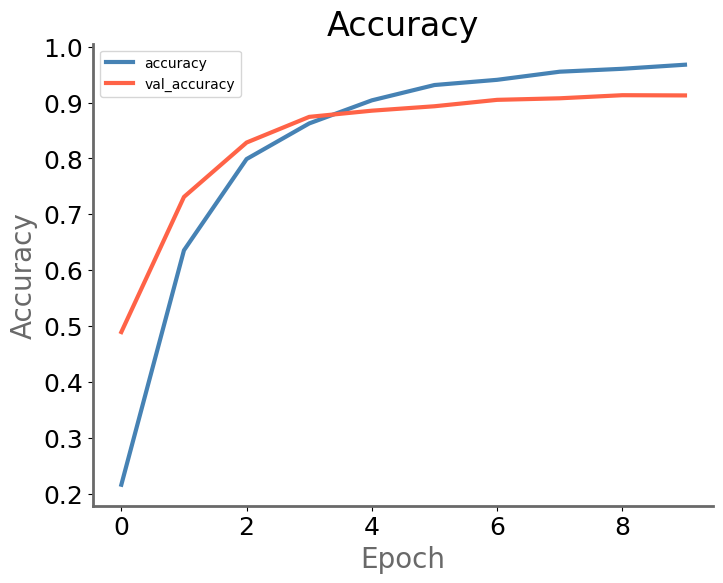

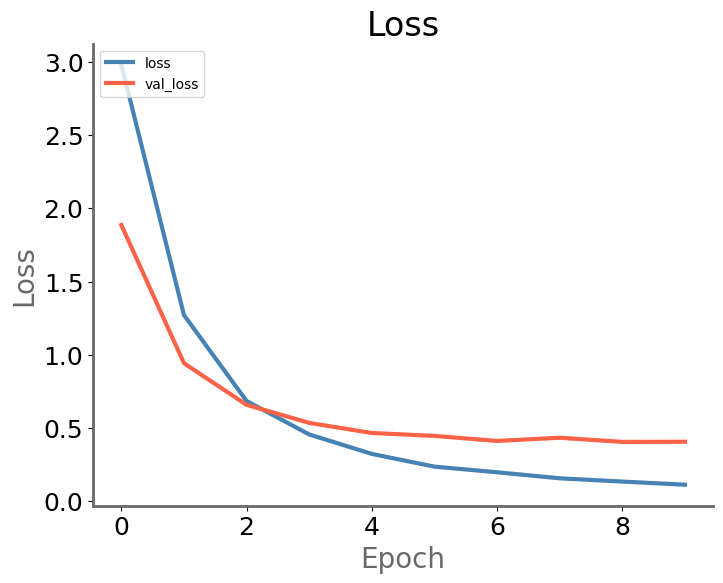

In [18]:
fidle.scrawler.history(history, save_as='03-history')

## Step 8 - Evaluation and confusion

79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step


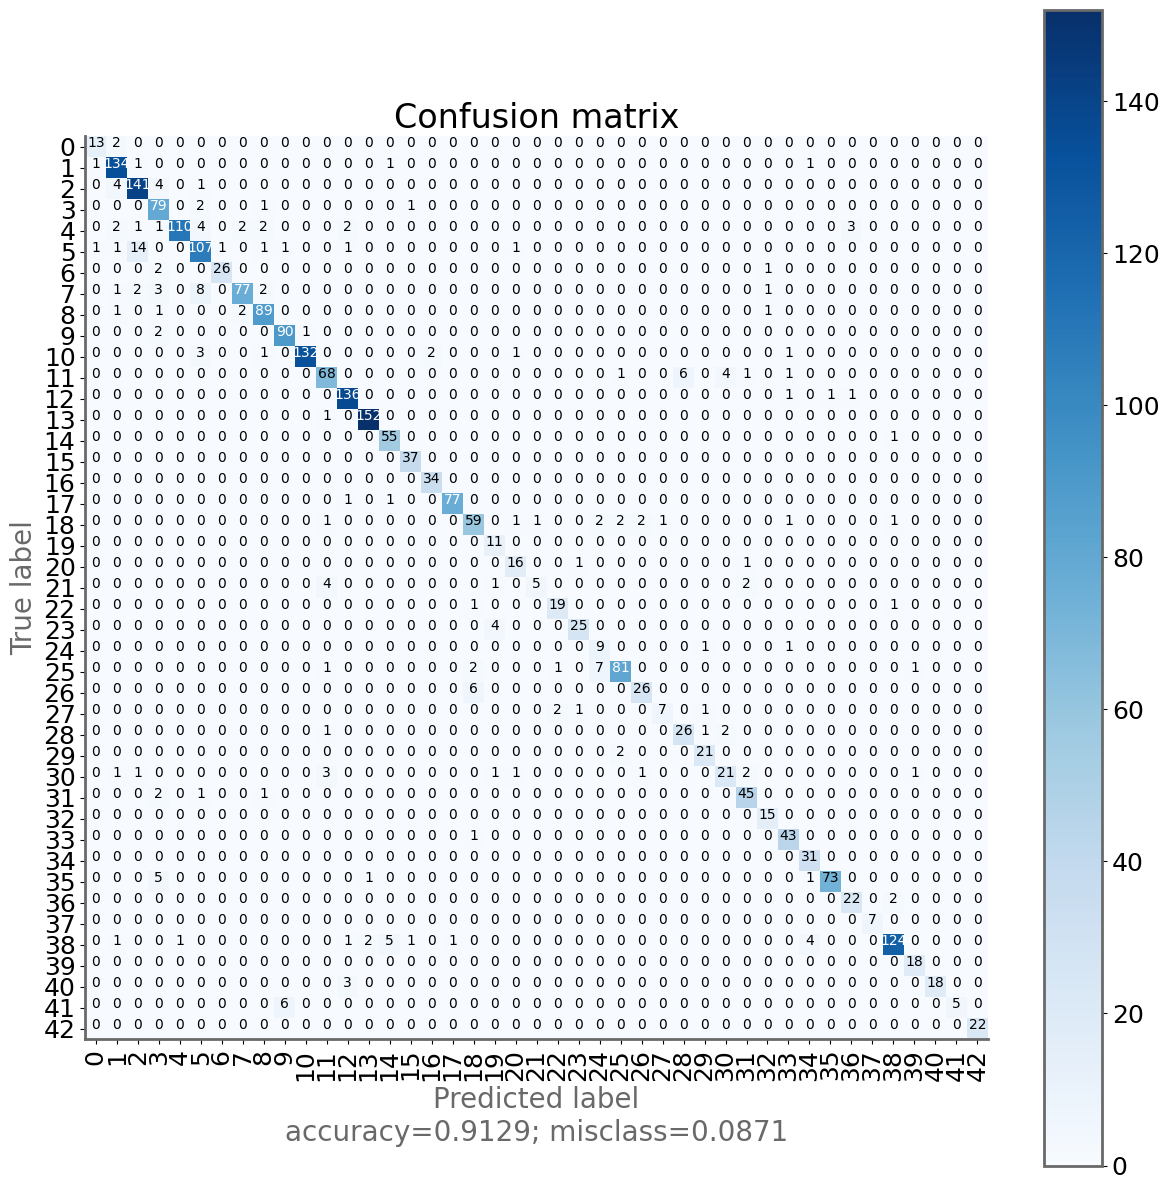

In [19]:
y_sigmoid = model.predict(x_test, verbose=fit_verbosity)
y_pred    = np.argmax(y_sigmoid, axis=-1)

fidle.scrawler.confusion_matrix(y_test,y_pred,range(43), figsize=(12, 12),normalize=False, save_as='04-confusion-matrix')

## Step 9 - Restore and evaluate
#### List saved models :

In [20]:
# !ls -1rt "$run_dir"/models/

#### Restore a model :

In [21]:
loaded_model = keras.models.load_model(f'{run_dir}/models/best-model.keras')
# loaded_model.summary()
print("Loaded.")

Loaded.


#### Evaluate it :

In [22]:
score = loaded_model.evaluate(x_test, y_test, verbose=0)

print('Test loss      : {:5.4f}'.format(score[0]))
print('Test accuracy  : {:5.4f}'.format(score[1]))

Test loss      : 0.4073
Test accuracy  : 0.9133


#### Make a prediction :

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


<br>**Output layer from model is (x100) :**

[[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0. 100.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.]]


<br>**Graphically :**

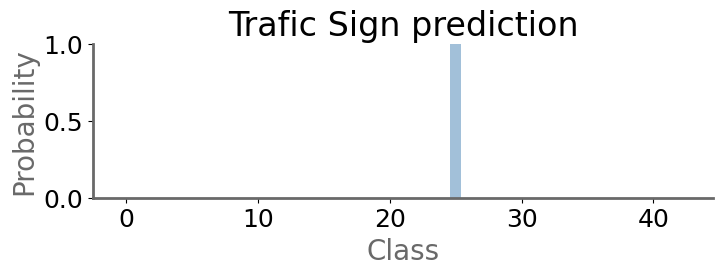

<br>**In pictures :**


The image :               Prediction :            Real stuff:


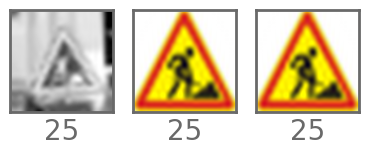

YEEES ! that's right!


In [23]:
# ---- Pick a random image
#
i   = random.randint(1,len(x_test))
x,y = x_test[i], y_test[i]

# ---- Do prediction
#
prediction = loaded_model.predict( np.array([x]), verbose=fit_verbosity )

# ---- Show result

my_tools.show_prediction( prediction, x, y, x_meta )

In [24]:
fidle.end()

**End time :** 05/07/24 10:30:46  
**Duration :** 00:06:45 441ms  
This notebook ends here :-)  
[https://fidle.cnrs.fr](https://fidle.cnrs.fr)

## Step 10 - To go further ;-)
What you can do:
- Try differents models
- Use a subset of the dataset
- Try different datasets
- Try to recognize exotic signs !
- Test different hyperparameters (epochs, batch size, optimization, etc.
 

---
<img width="80px" src="../fidle/img/logo-paysage.svg"></img>